# Data processing

In [1]:
import JupyterNotebooksLib as slicernb

# Set image viewer size to 50% (fill half of a cell)
slicernb.AppWindow.setWindowSize(scale=0.5)
slicernb.AppWindow.setContents("viewers")

## Image processing

In [2]:
# Clear scene
slicer.mrmlScene.Clear(False)

# Load data
import SampleData
volume = slicer.util.loadVolume('data/MRBrainTumor1.nrrd')

# Create output node
blurredVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", "Filtered")
blurredVolume.CreateDefaultDisplayNodes()

# Show 3-over-3 compare layout with original and blurred volume
slicernb.showSliceViewAnnotations(True)
slicernb.setViewLayout("ThreeOverThree")
layoutManager = slicer.app.layoutManager()
for sliceViewName in layoutManager.sliceViewNames():
    sliceWidget = layoutManager.sliceWidget(sliceViewName)
    volumeNodeToShow = volume if sliceWidget.mrmlSliceNode().GetViewGroup() == 0  else blurredVolume
    sliceWidget.mrmlSliceCompositeNode().SetBackgroundVolumeID(volumeNodeToShow.GetID())

# Create a function for performing the filtering.
# This will be executed whenever the slider is moved and released.
def threshold(lower=-20, upper=180):
    parameters = {
        "InputVolume": volume.GetID(),
        "OutputVolume": blurredVolume.GetID(),
        "Lower": lower,
        "Upper": upper
        }
    slicer.cli.runSync(slicer.modules.thresholdscalarvolume, parameters=parameters, update_display=False)
    return slicernb.ViewDisplay("ThreeOverThree")

# Create slider
from ipywidgets import FloatSlider, interact
i=interact(threshold,
         lower=FloatSlider(150, min=-50, max=300, step=5, continuous_update=False),
         upper=FloatSlider(250, min=-50, max=300, step=5, continuous_update=False))

interactive(children=(FloatSlider(value=150.0, continuous_update=False, description='lower', max=300.0, min=-5…

## Create model from volume

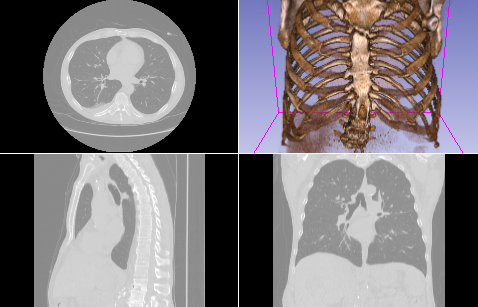

In [3]:
# Clear scene
slicer.mrmlScene.Clear(False)

import SampleData
volume = SampleData.SampleDataLogic().downloadCTChest()

# Volume render a small (30%) image
slicernb.AppWindow.setWindowSize(scale=0.3)
slicernb.showVolumeRendering(volume)
slicernb.showSliceViewAnnotations(False)

display(slicernb.ViewDisplay("FourUp"))

# Disable volume rendering to make sure it does not slow down execution
slicernb.showVolumeRendering(volume, False)

In [4]:
# Print all parameters of a CLI module
cliModule = slicer.modules.grayscalemodelmaker
n=cliModule.cliModuleLogic().CreateNode()
for groupIndex in range(n.GetNumberOfParameterGroups()):
  for parameterIndex in range(n.GetNumberOfParametersInGroup(groupIndex)):
    print('Parameter ({0}/{1}): {2} ({3})'.format(groupIndex, parameterIndex, n.GetParameterName(groupIndex, parameterIndex), n.GetParameterLabel(groupIndex, parameterIndex)))

Parameter (0/0): InputVolume (Input Volume)
Parameter (0/1): OutputGeometry (Output Geometry)
Parameter (1/0): Threshold (Threshold)
Parameter (1/1): Name (Model Name)
Parameter (1/2): Smooth (Smooth)
Parameter (1/3): Decimate (Decimate)
Parameter (1/4): SplitNormals (Split Normals?)
Parameter (1/5): PointNormals (Compute Point Normals?)
Parameter (2/0): Debug (Debug)


Creating mesh from volume...


IntProgress(value=0)

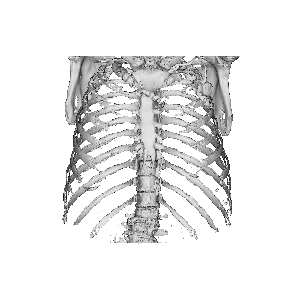

In [5]:
# Interactive CLI module execution (with progress reporting)

parameters = {}
parameters["InputVolume"] = volume.GetID()
parameters["Threshold"] = 220
outModel = slicer.vtkMRMLModelNode()
slicer.mrmlScene.AddNode( outModel )
parameters["OutputGeometry"] = outModel.GetID()
grayMaker = slicer.modules.grayscalemodelmaker
print("Creating mesh from volume...")
slicernb.cliRunSync(grayMaker, None, parameters)

# Model display in custom orientation
slicernb.ModelDisplay(outModel, orientation=[0,-90,0])

In [6]:
# Set CLI module parameters using interactive widget

from ipywidgets import interact_manual
@interact_manual(threshold=(-500.0,1200,5))
def h(threshold=-100):
    parameters["Threshold"] = threshold
    slicernb.cliRunSync(grayMaker, None, parameters)
    return slicernb.ModelDisplay(outModel, orientation=[0,-90,0])

interactive(children=(FloatSlider(value=-100.0, description='threshold', max=1200.0, min=-500.0, step=5.0), Bu…

In [7]:
# Download created model

# Save file to local folder
outputFile = "segmented-model.stl"
slicer.util.saveNode(outModel, slicernb.localPath(outputFile))

# Show link
from IPython.display import FileLink
FileLink(outputFile)

/home/sliceruser/nb/segmented-model.stl

#### Run this example in your browser using Binder: [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/slicer/SlicerNotebooks/master?filepath=02_Data_processing.ipynb)